In [209]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [210]:
tasks_fn = 'resources/house_target_tuple.json'
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
folds = ["train", "val_seen", "val_unseen", "test"]

with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [211]:
# Enumerate distances inside of task tuple data.
task_ds = []
for house in house_target_tuple:
    for _, _, _, _, end_pano_ds in house_target_tuple[house]:
        task_ds.append(min(end_pano_ds))

In [212]:
# Enumrate distances inside of matterport R2R data.
mp_ds = []
for fn in ['../../../tasks/R2R/data/R2R_train.json',
           '../../../tasks/R2R/data/R2R_val_seen.json',
           '../../../tasks/R2R/data/R2R_val_unseen.json']:
    with open(fn, 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        mp_ds.append(len(trajectory['path']))

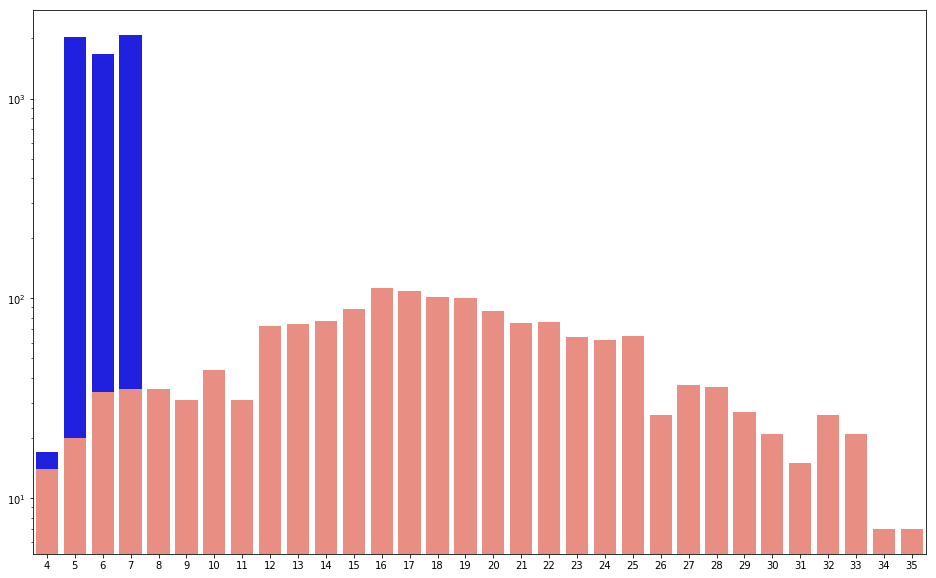

MPD average hops:	18.21+/-6.68, (n=1629)
MP R2R average hops:	6.00+/-0.85, (n=5798)


In [213]:
# Visualize tuple path distances.
bin_size = 1

freq_of_task_ds_count_bins = {}
for c in task_ds:
    cbin = c // bin_size
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
    freq_of_task_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_task_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_task_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0

fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_mp_ds_count_bins],
                 y=[freq_of_mp_ds_count_bins[k] for k in freq_of_mp_ds_count_bins],
                 color="blue")
g2 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_task_ds_count_bins],
                 y=[freq_of_task_ds_count_bins[k] for k in freq_of_task_ds_count_bins],
                 color="salmon")
ax.set(yscale="log")
plt.show()

print("MPD average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(task_ds), np.std(task_ds), len(task_ds)))
print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))

In [214]:
# Load games data.
with open(games_fn, 'r') as f:
    games = pd.read_json(json.load(f))

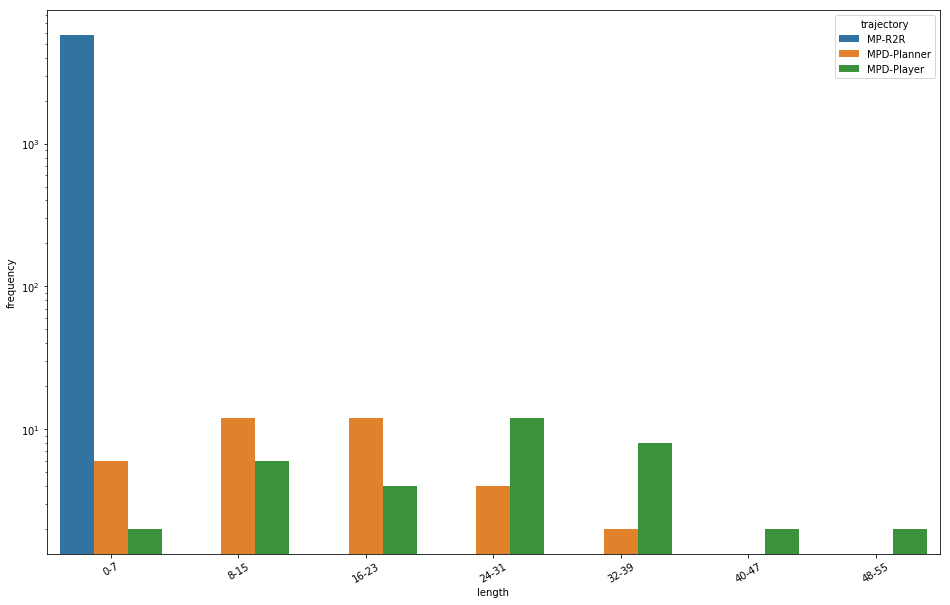

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD Player average hops:	26.94+/-12.18, (n=36)
MPD Planner average hops:	16.72+/-7.44, (n=36)


In [215]:
# Examine distribution of dialog navigation lengths versus MatterPort.
bin_size = 8

ins_ds = [len(games['planner_nav_steps'][idx]) for idx in games.index]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(games['nav_steps'][idx]) for idx in games.index]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': "%d-%d" % (k * bin_size, (k+1) * bin_size - 1) if bin_size > 1 else k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
if bin_size > 1:
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [216]:
# Load instruction following data.
ins_follow = []
print("fold, instances, scans")
for fold in folds:
    with open(os.path.join(instruction_following_dir, "%s.json" % fold), 'r') as f:
        fold_trajs = json.load(f)
        fold_scans = set([traj['scan'] for traj in fold_trajs])
        ins_follow.extend(fold_trajs)
        print("%s, %d, %d" % (fold, len(fold_trajs), len(fold_scans)))

fold, instances, scans
train, 87, 10
val_seen, 5, 2
val_unseen, 18, 3
test, 14, 3


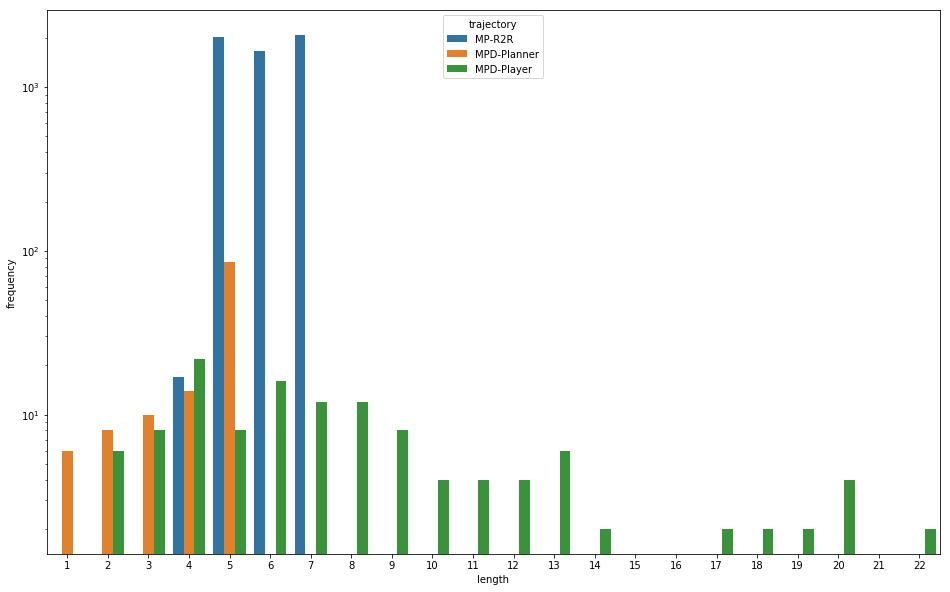

MP R2R average hops:	6.00+/-0.85, (n=5798)
MPD IF Player average hops:	7.92+/-4.78, (n=124)
MPD IF Planner average hops:	4.34+/-1.16, (n=124)


In [217]:
# Examine distribution of instruction following lengths versus MatterPort.
bin_size = 1

ins_ds = [len(task['planner_path']) for task in ins_follow]
freq_of_ins_ds_count_bins = {}
for c in ins_ds:
    cbin = c // bin_size
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0
    freq_of_ins_ds_count_bins[cbin] += 1
    
player_ds = [len(task['player_path']) for task in ins_follow]
freq_of_player_ds_count_bins = {}
for c in player_ds:
    cbin = c // bin_size
    if cbin not in freq_of_player_ds_count_bins:
        freq_of_player_ds_count_bins[cbin] = 0
    freq_of_player_ds_count_bins[cbin] += 1

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1

for cbin in range(min(min(freq_of_mp_ds_count_bins), min(freq_of_ins_ds_count_bins), min(freq_of_player_ds_count_bins)),
                  max(max(freq_of_mp_ds_count_bins), max(freq_of_ins_ds_count_bins), max(freq_of_player_ds_count_bins)) + 1):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    if cbin not in freq_of_ins_ds_count_bins:
        freq_of_ins_ds_count_bins[cbin] = 0

d = [{'length': k * bin_size,
      'trajectory': 'MP-R2R',
      'frequency': freq_of_mp_ds_count_bins[k]} for k in freq_of_mp_ds_count_bins]
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Planner',
           'frequency': freq_of_ins_ds_count_bins[k]} for k in freq_of_ins_ds_count_bins])
d.extend([{'length': k * bin_size,
           'trajectory': 'MPD-Player',
           'frequency': freq_of_player_ds_count_bins[k]} for k in freq_of_player_ds_count_bins])
fig, ax = plt.subplots(figsize=(16, 10))
df = pd.DataFrame(d)
g = sns.barplot(ax=ax, x='length', y='frequency', hue="trajectory", data=df)
ax.set(yscale="log")
plt.show()

print("MP R2R average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(mp_ds), np.std(mp_ds), len(mp_ds)))
print("MPD IF Player average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(player_ds), np.std(player_ds), len(player_ds)))
print("MPD IF Planner average hops:\t%.2f+/-%.2f, (n=%d)" % (np.mean(ins_ds), np.std(ins_ds), len(ins_ds)))

In [218]:
# Examine human performance on the instruction following and dialog tasks based on official R2R metrics.
for task in ins_follow:
    ins_sr += stop_success(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
    ins_osr += oracle_success(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
    ins_spl += spl(task['scan'], task['player_path'], task['planner_path'], within_meters=3)
ins_sr = sum([ins_follow[idx]['R2R_success'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_osr = sum([ins_follow[idx]['R2R_oracle_success'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_spl = sum([ins_follow[idx]['R2R_spl'] for idx in range(len(ins_follow))]) / len(ins_follow)
ins_ospl = sum([ins_follow[idx]['R2R_oracle_spl'] for idx in range(len(ins_follow))]) / len(ins_follow)
print(ins_sr, ins_osr, ins_spl, ins_ospl)

dia_spl = sum(games['R2R_spl']) / len(games)
dia_ospl = sum(games['R2R_oracle_spl']) / len(games)
print(dia_spl, dia_ospl)

0.3064516129032258 0.7741935483870968 0.06034306195596519 0.4568736371155727
0.03632254222222222 0.08492222270555555
